Based on the precision recall scores we will take the bessed preproprossing/modeling combination and perform variable reduction to see if we can improve scores.

Preprocessing Method: MinMaxScaler

Imbalanced Data Method: RandomUnderSampler

Model: Logistic Regression

Variables to keep: TotalCharges, tenure, MonthlyCharges

This means we will drop all categorical data so there is no need for dummy variables.

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn import model_selection
from imblearn.under_sampling import RandomUnderSampler
import scipy.stats as stats

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

In [60]:
file = '/Users/tshields/Documents/GitHub/Churn/Data/churn_data_cleaned.csv'

In [61]:
df = pd.read_csv(file, index_col=0)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Drop all columns except the target variable, TotalCharges, tenure, and MonthlyCharges

In [62]:
X = df._get_numeric_data()
X.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


In [63]:
num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tenure          7032 non-null   int64  
 1   MonthlyCharges  7032 non-null   float64
 2   TotalCharges    7032 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 219.8 KB


# Scaling Numeric Values using MinMaxScaler

In [64]:


features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features
X.head()

,tenure,MonthlyCharges,TotalCharges
0,0.000000,0.115423,0.001275
1,0.464789,0.385075,0.215867
2,0.014085,0.354229,0.010310
3,0.619718,0.239303,0.210241
4,0.014085,0.521891,0.015330


# Encoding Target Variable

In [65]:
df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)
y = df['Churn']
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

## Splitting the data

In [66]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25)

## Fit predictor and target variable using RandomUnderSampler

In [68]:
rus = RandomUnderSampler(random_state=42, replacement=True)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [69]:
import sklearn.model_selection

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(X_rus, y_rus)
# Print the accuracy from the testing data.
print('Recall Score: ', recall_score(clf.predict(X_test), y_test))
print('Precision Score: ', precision_score(clf.predict(X_test), y_test))

Recall Score:  0.5063291139240507
Precision Score:  0.7086614173228346


### Model Tuning using Grid Search

In [70]:
from sklearn.model_selection import GridSearchCV

model=LogisticRegression()
Cs = {'C': [0.001, 0.1, 1, 10, 100]}
b_model= GridSearchCV(model, Cs, cv=5)
b_model.fit(X_rus, y_rus)
y_pred=b_model.predict(X_test)

precision_score = precision_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)
print('Recall Score: ', recall_score)
print('Precision Score: ', precision_score)

Recall Score:  0.7204724409448819
Precision Score:  0.5097493036211699


In [71]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5): # this function implement clf as a dictionary and split thr training sets into 5 folds.
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_) 
    best = gs.best_estimator_
    return best 

In [72]:
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain) # obtaining the best classify using cv_optimize
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.2f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.2f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [73]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(), 
                                                           {"C": [0.01, 0.1, 1, 10, 100]}, 
                                                           df, ['TotalCharges','tenure', 'MonthlyCharges'], 'Churn', 1)

BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.78
Accuracy on test data:     0.78


In [74]:
print("\nClassification report:\n", classification_report(y_test, y_pred))


Classification report:
               precision    recall  f1-score   support

           0       0.86      0.72      0.78      1250
           1       0.51      0.72      0.60       508

    accuracy                           0.72      1758
   macro avg       0.69      0.72      0.69      1758
weighted avg       0.76      0.72      0.73      1758



In [77]:
def calc_precision_recall(y_true, y_pred):
    
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Instantiate counters
    TP = 0
    FP = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_true.index: 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1
    
    # Calculate true positive rate and false positive rate
    # Use try-except statements to avoid problem of dividing by 0
    try:
        precision = TP / (TP + FP)
    except:
        precision = 1
    
    try:
        recall = TP / (TP + FN)
    except:
        recall = 1
    return precision, recall

# Test function

calc_precision_recall(y_test, y_pred)    

(0.5097493036211699, 0.7204724409448819)

In [78]:
# Fit and predict test class probabilities
lr = LogisticRegression(max_iter=10000, penalty='none')
lr.fit(X_train, y_train)
y_test_probs = lr.predict_proba(X_test)[:,1]

# Containers for true positive / false positive rates
precision_scores = []
recall_scores = []

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0, 1, num=100)

# Find true positive / false positive rate for each threshold
for p in probability_thresholds:
    
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    precision, recall = calc_precision_recall(y_test, y_test_preds)
        
    precision_scores.append(precision)
    recall_scores.append(recall)

In [79]:
# LOGISTIC REGRESSION (L2 REGULARIZATION)

# Fit and predict test class probabilities
lr_l2 = LogisticRegression(max_iter=1000, penalty='l2')
lr_l2.fit(X_train, y_train)
y_test_probs = lr_l2.predict_proba(X_test)[:,1]

# Containers for true positive / false positive rates
l2_precision_scores = []
l2_recall_scores = []

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0,1,num=100)

# Find true positive / false positive rate for each threshold
for p in probability_thresholds:
    
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    precision, recall = calc_precision_recall(y_test, y_test_preds)
        
    l2_precision_scores.append(precision)
    l2_recall_scores.append(recall)

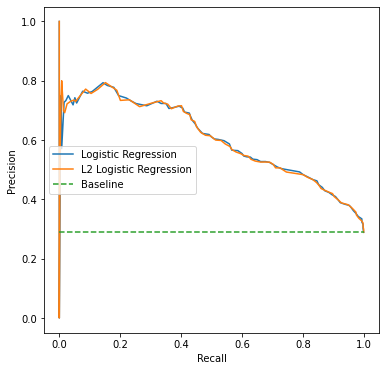

In [80]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(recall_scores, precision_scores, label='Logistic Regression')
ax.plot(l2_recall_scores, l2_precision_scores, label='L2 Logistic Regression')
baseline = len(y_test[y_test==1]) / len(y_test)
ax.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc='center left');

In [82]:
from sklearn.metrics import auc, average_precision_score

print(f'LR (No reg.) AUC-PR: {round(auc(recall_scores, precision_scores),2)}')
print(f'LR(L2 reg.) AUC-PR: {round(auc(l2_recall_scores, l2_precision_scores),2)}')
print('\n')
print(f'LR (No reg.) Avg. Prec.: {round(average_precision_score(y_test, lr.predict_proba(X_test)[:,1]),2)}')
print(f'LR (L2 reg.) Avg. Prec.: {round(average_precision_score(y_test, lr_l2.predict_proba(X_test)[:,1]),2)}')


LR (No reg.) AUC-PR: 0.6
LR(L2 reg.) AUC-PR: 0.6


LR (No reg.) Avg. Prec.: 0.61
LR (L2 reg.) Avg. Prec.: 0.61


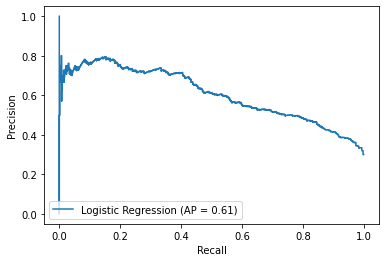

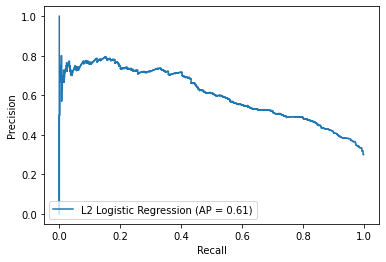

In [84]:
#Use sklearn to plot precision-recall curves

from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(lr, X_test, y_test, name = 'Logistic Regression')
plot_precision_recall_curve(lr_l2, X_test, y_test, name = 'L2 Logistic Regression');